# RNA structure deviation prediction

In [1]:
import xml.etree.ElementTree as ET
from pathlib import Path

import biographs as bg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from catboost.score_function import me
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_networkx

## Data

In [2]:
challanges = ["pz0" + str(i) for i in range(1, 10)] + ["pz10"]
challanges

['pz01',
 'pz02',
 'pz03',
 'pz04',
 'pz05',
 'pz06',
 'pz07',
 'pz08',
 'pz09',
 'pz10']

In [3]:
motives = pd.DataFrame()

for challange in challanges:
    motive_df = pd.read_csv(
        f"RNA-Puzzles/{challange}/filter-results.txt",
        delimiter="\t",
        header=None,
        names=[
            "filename",
            "number_of_schemes",
            "number_of_rests",
            "nucleotide ranges",
            "sequence",
        ],
    )
    motive_df["challange_num"] = challange
    motives = pd.concat([motives, motive_df])

motives = motives.reset_index(drop=True)
motives.shape

(1114, 6)

In [4]:
motives

,filename,number_of_schemes,number_of_rests,nucleotide ranges,sequence,challange_num
0,1_solution_0_rpr_A_3_G,2,15,"A1-A7, B11-B18","CCGCCGC, AUGCCUGU",pz01
1,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
2,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
3,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
4,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
...,...,...,...,...,...,...
1109,10_0_solution_4LCK_rpr_B_60_C,2,22,"B13-B20, B51-B64","CAGUGGUA, GGUUCGAAUCCCGU",pz10
1110,10_0_solution_4LCK_rpr_B_61_C,2,22,"B14-B19, B50-B65","AGUGGU, GGGUUCGAAUCCCGUC",pz10
1111,10_0_solution_4LCK_rpr_B_62_C,2,17,"B49-B55, B57-B66","CGGGUUC, AAUCCCGUCU",pz10
1112,10_0_solution_4LCK_rpr_B_63_G,2,15,"B48-B54, B59-B66","GCGGGUU, UCCCGUCU",pz10


In [5]:
def parse_scores_xml(xml_path: Path) -> pd.DataFrame:
    tree = ET.parse(xml_path)
    root = tree.getroot()

    structure_dicts = []
    for structure in root.iter("structure"):
        filename = structure.find("description").find("filename").text
        score = structure.find("score").text
        structure_dicts.append({"filename": filename, "score": score})

    return pd.DataFrame(structure_dicts)

In [6]:
solutions_with_no_xml_file = []
scores_df = pd.DataFrame()
PUZZLES_DIR = Path("./RNA-Puzzles")

for index, row in motives.iterrows():
    challange_dir = PUZZLES_DIR / f"{row['challange_num']}"
    xml_path = challange_dir / f"{row['filename']}-rmsd.xml"

    if xml_path.exists():
        xml_df = parse_scores_xml(xml_path)
        xml_df["solution"] = row["filename"]
        xml_df[
            "pdb_path"
        ] = f"{PUZZLES_DIR.name}/{challange_dir.name}/{row['filename']}/" + xml_df[
            "filename"
        ].astype(
            str
        )

        xml_df[
            "tor_path"
        ] = f"{PUZZLES_DIR.name}/{challange_dir.name}/{row['filename']}/" + xml_df[
            "filename"
        ].apply(
            lambda x: str(x[:-3]) + "tor"
        )

        scores_df = pd.concat([scores_df, xml_df])
    else:
        solutions_with_no_xml_file.append(index)

scores_df.shape

(34114, 5)

In [7]:
scores_df

,filename,score,solution,pdb_path,tor_path
0,1_bujnicki_1_rpr.pdb,4.643,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
1,1_bujnicki_2_rpr.pdb,4.495,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
2,1_bujnicki_3_rpr.pdb,3.862,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
3,1_bujnicki_4_rpr.pdb,4.514,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
4,1_bujnicki_5_rpr.pdb,4.617,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
...,...,...,...,...,...
21,10_DING_5_rpr.pdb,2.963,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
22,10_DING_6_rpr.pdb,2.19,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
23,10_DING_7_rpr.pdb,2.374,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
24,10_DING_8_rpr.pdb,2.918,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...


In [8]:
motives = motives.drop(solutions_with_no_xml_file)
motives.shape

(1095, 6)

In [9]:
def parse_tor_file(tor_file_path: Path) -> dict:
    tor_df = pd.read_csv(tor_file_path, delimiter="\t", na_values="-")
    tor_df = tor_df.loc[
        :,
        [
            "Chain",
            "ResNum",
            "alpha",
            "beta",
            "gamma",
            "delta",
            "epsilon",
            "zeta",
            "chi",
        ],
    ].fillna(0)

    names = tor_df.loc[:, "Chain"] + tor_df.loc[:, "ResNum"].astype(str)

    tor_angles = tor_df.loc[
        :, ["alpha", "beta", "gamma", "delta", "epsilon", "zeta", "chi"]
    ].values.tolist()

    return {name: tor_angle for name, tor_angle in zip(names, tor_angles)}

In [10]:
def pbd_to_graph(pdb_file_path: Path, tor_file_path: Path) -> nx.Graph:
    solution = bg.Pmolecule(str(pdb_file_path))
    solution_graph = solution.network(cutoff=5, weight=False)
    features_dict = parse_tor_file(tor_file_path)
    nx.set_node_attributes(
        solution_graph,
        features_dict,
        name="x",
    )
    return solution_graph

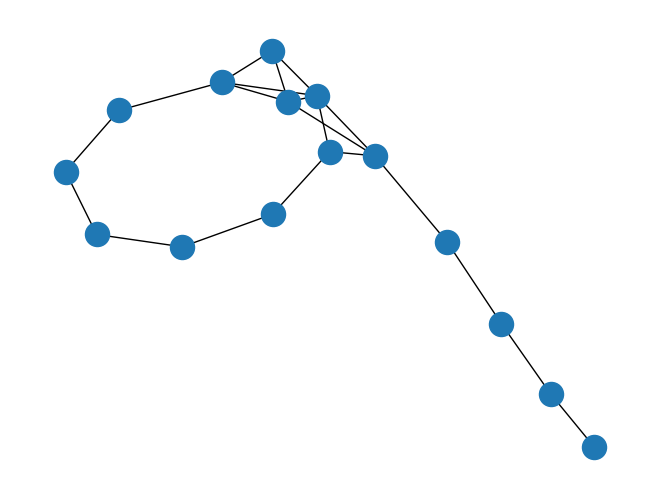

NodeView(('A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18'))

In [11]:
sample_graph = pbd_to_graph(
    PUZZLES_DIR / "pz01" / "1_solution_0_rpr_A_3_G.pdb",
    PUZZLES_DIR / "pz01" / "1_solution_0_rpr_A_3_G.tor",
)

nx.draw(sample_graph)
plt.show()
sample_graph.nodes

In [12]:
pdb_files = scores_df["pdb_path"]
pdb_files.shape

(34114,)

In [13]:
tor_files = scores_df["tor_path"]
tor_files.shape

(34114,)

In [14]:
labels = scores_df["score"]
labels.shape

(34114,)

In [15]:
MAX_FEATURES = 427

X_list = []
y_list = []

for pdb, tor, label in zip(pdb_files, tor_files, labels):
    try:
        graph = pbd_to_graph(
            Path(pdb),
            Path(tor),
        )
        x_tmp = from_networkx(graph).x.flatten().numpy()
        x = np.zeros(MAX_FEATURES)
        x[: x_tmp.shape[0]] = x_tmp
        X_list.append(x)
        y_list.append(label)
    except:
        print(f"Error in file {tor}")
len(X_list)

Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_8_G/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_9_C/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_12_U/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_17_G/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_A_18_U/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_B_7_C/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_B_8_G/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_B_13_G/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz01/1_solution_0_rpr_B_14_C/1_dokholyan_1_rpr.tor
Error in file RNA-Puzzles/pz06/6_0_solution_4GXY_rpr_A_4_C/6_Chen_5_rpr.tor
Error in file RNA-Puzzles/pz06/6_0_solution_4GXY_rpr_A_4_C/6_Chen_7_rpr.tor
Error in file RNA-Puzzles/pz06/6_0_solution_4GXY_rpr_A_5_A/6_Chen_5_rpr.tor
Error i

33422

In [16]:
X = np.array(X_list)
X.shape

(33422, 427)

In [17]:
y = np.array(y_list).astype(float)
y.shape

(33422,)

### RandomForest and CatBoost

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=23, test_size=0.3
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=23, test_size=0.3
)

In [20]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 16376
Validation samples: 7019
Test samples: 10027


In [30]:
def root_mean_squared_error(y_true: np.array, y_pred: np.array) -> float:
    return pow(mean_squared_error(y_true, y_pred), 0.5)

In [35]:
model_rf = RandomForestRegressor(random_state=23)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=23)

In [44]:
y_pred_rf = model_rf.predict(X_test)
score_rf = root_mean_squared_error(y_test, y_pred_rf)
print(f"RMSE for {model_rf.__class__.__name__} score_rf: {score_rf}")

RMSE for RandomForestRegressor score_rf: 4.78605683815697


In [45]:
model_cb = CatBoostRegressor(iterations=2000, eval_metric="RMSE")
model_cb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

Learning rate set to 0.051749
0:	learn: 6.9629227	test: 6.7119390	best: 6.7119390 (0)	total: 63.2ms	remaining: 2m 6s
1:	learn: 6.9064571	test: 6.6570600	best: 6.6570600 (1)	total: 78.4ms	remaining: 1m 18s
2:	learn: 6.8505509	test: 6.6027338	best: 6.6027338 (2)	total: 92.8ms	remaining: 1m 1s
3:	learn: 6.8025263	test: 6.5555724	best: 6.5555724 (3)	total: 109ms	remaining: 54.2s
4:	learn: 6.7553727	test: 6.5110153	best: 6.5110153 (4)	total: 124ms	remaining: 49.6s
5:	learn: 6.7121139	test: 6.4678783	best: 6.4678783 (5)	total: 139ms	remaining: 46.1s
6:	learn: 6.6728973	test: 6.4291831	best: 6.4291831 (6)	total: 154ms	remaining: 43.9s
7:	learn: 6.6320535	test: 6.3884899	best: 6.3884899 (7)	total: 170ms	remaining: 42.2s
8:	learn: 6.5948000	test: 6.3531622	best: 6.3531622 (8)	total: 189ms	remaining: 41.8s
9:	learn: 6.5589463	test: 6.3175018	best: 6.3175018 (9)	total: 205ms	remaining: 40.7s
10:	learn: 6.5285930	test: 6.2875197	best: 6.2875197 (10)	total: 220ms	remaining: 39.8s
11:	learn: 6.49885

In [46]:
y_pred_cb = model_cb.predict(X_test)
score_cb = root_mean_squared_error(y_test, y_pred_cb)
print(f"RMSE for {model_cb.__class__.__name__} score_rf: {score_cb}")

RMSE for CatBoostRegressor score_rf: 4.273929696624889
